In [109]:
# import gdown
# from pyro.infer import SVI, JitTrace_ELBO, Trace_ELBO, TraceGraph_ELBO
# from pyro.optim import Adam
# import os
# import pyro
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
import re
import pyro.distributions as pyrodist
import scanpy as sc
import seaborn as sns
from datetime import datetime
import time
import toolz
import torch
import torch.utils.data
import torchvision.utils as vutils
import umap
import skimage as skim
from abc import abstractmethod
from anndata.experimental.pytorch import AnnLoader
from importlib import reload
from math import pi, sin, cos, sqrt, log
import sklearn
from sklearn import datasets as skds
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import mixture
from toolz import partial, curry
from toolz import groupby, count, reduce, reduceby, countby, identity
from torch import nn, optim, distributions, Tensor
from torch.nn.functional import one_hot
from torchvision import datasets, transforms, models
from torchvision.utils import save_image, make_grid
from typing import Callable, Iterator, Union, Optional, TypeVar
from typing import List, Set, Dict, Tuple
from typing import Mapping, MutableMapping, Sequence, Iterable
from typing import Union, Any, cast, IO, TextIO
from torch.utils.data import WeightedRandomSampler
from scipy import stats
# my own sauce
from my_torch_utils import denorm, normalize, mixedGaussianCircular
from my_torch_utils import fclayer, init_weights, buildNetwork
from my_torch_utils import fnorm, replicate, logNorm, log_gaussian_prob
from my_torch_utils import plot_images, save_reconstructs, save_random_reconstructs
from my_torch_utils import scsimDataset
import my_torch_utils as ut
from importlib import reload
from torch.nn import functional as F
import gmmvae03 as M3
import gmmvae04 as M4
import gmmvae05 as M5
import gmmvae06 as M6
import gmmvae07 as M7
import gmmvae08 as M8
import gmmvae09 as M9
import gmmvae10 as M10
import gmmvae11 as M11
import gmmvae12 as M12
import gmmvae13 as M13
import gmmvae14 as M14
import gmmvae15 as M15
import gmmvae16 as M16
import gmmvaeBeta00 as Mb0
import gmmTraining as Train

print(torch.cuda.is_available())

#plt.ion()
#sc.settings.verbosity = 3
#sc.logging.print_header()
# sc.settings.set_figure_params(dpi=120, facecolor='white', )
# sc.settings.set_figure_params(figsize=(8,8), dpi=80, facecolor='white', )
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
)


True


In [110]:
enc = OneHotEncoder(sparse=False, dtype=np.float32)
enc_ct = LabelEncoder()


@curry
def binarize(x: torch.Tensor, threshold: float = 0.25) -> torch.Tensor:
    ret = (x > threshold).float()
    return ret


transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)
train_dataset = datasets.MNIST(
    "data/",
    train=True,
    download=True,
    transform=transform,
)
test_dataset = datasets.MNIST(
    "data/",
    train=False,
    download=True,
    transform=transform,
)
train_data = train_dataset.data.float() / 255
test_data = test_dataset.data.float() / 255
train_labels = F.one_hot(
    train_dataset.targets.long(),
    num_classes=10,
).float()
test_labels = F.one_hot(
    test_dataset.targets.long(),
    num_classes=10,
).float()

data_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            train_data,
            train_labels,
            train_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=ut.SynteticDataSetV2(
        dati=[
            test_data,
            test_labels,
            test_labels,
        ],
    ),
    batch_size=128,
    shuffle=True,
)

In [111]:
adata = sc.AnnData(X = test_data.flatten(1).detach().numpy())
adata.obs['labels'] = test_labels.argmax(-1).numpy().astype(str)


In [42]:
reload(Mb0)
# CVAE
# p(x|z)p(z|c)p(c)
# q(z|x,c)
model = Mb0.VAE_AE_TypeB1500vC2(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    nc1=10,
    #learned_prior=False,
    learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)


True
<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC2'>


In [43]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 531.4850463867188
loss_z: 24.441463470458984
total_loss: 555.926513671875

epoch's lr =  0.001
epoch 0
training phase
rec: 24.4226131439209
loss_z: 6.184047222137451
total_loss: 30.606660842895508

epoch's lr =  0.0001
epoch 0
training phase
rec: 23.403676986694336
loss_z: 6.3794355392456055
total_loss: 29.783111572265625

epoch's lr =  1e-05
epoch 0
training phase
rec: 20.62087059020996
loss_z: 6.3942365646362305
total_loss: 27.015106201171875

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


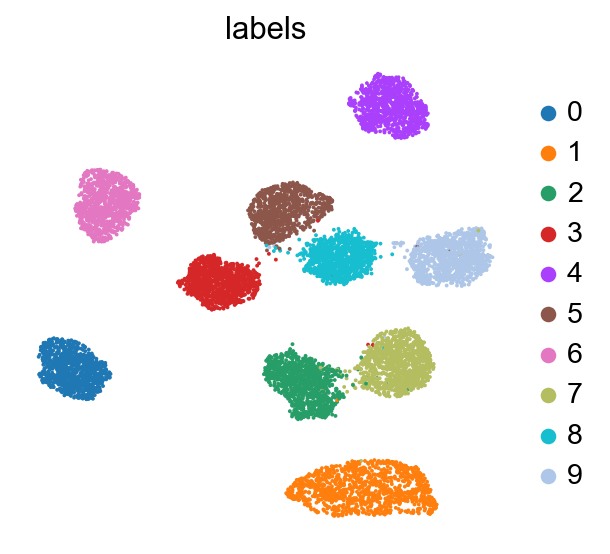

In [44]:
model.cpu()
output = model(test_data, cond1=test_labels )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


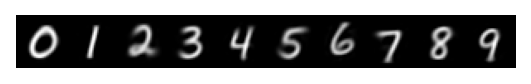

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 1.2579e-09,  1.2579e-09,  1.2579e-09],
         ...,
         [-2.4001e-05, -2.4001e-05, -2.4001e-05],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  0

In [45]:
model.eval()
test_labels.shape
c = torch.eye(10)
model.nz
cz = model.Pz(c)
cz.shape
x = model.Px(cz[:,:model.nz]).reshape(-1,1,28,28)
ut.plot_images(x)

In [46]:
# CVAE
# p(x|z)p(z)
# q(z|x,c)
model = Mb0.VAE_AE_TypeB1500vC2(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    nc1=10,
    learned_prior=False,
    #learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC2'>


In [47]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 519.7637939453125
loss_z: 5.320062637329102
total_loss: 525.0838623046875

epoch's lr =  0.001
epoch 0
training phase
rec: 23.577178955078125
loss_z: 9.172050476074219
total_loss: 32.749229431152344

epoch's lr =  0.0001
epoch 0
training phase
rec: 22.561071395874023
loss_z: 9.202316284179688
total_loss: 31.76338768005371

epoch's lr =  1e-05
epoch 0
training phase
rec: 21.27089500427246
loss_z: 9.369647026062012
total_loss: 30.640541076660156

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


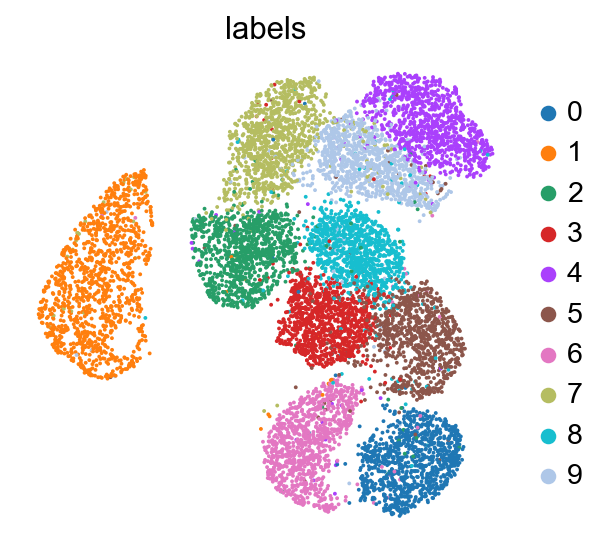

In [48]:
model.cpu()
output = model(test_data, cond1=test_labels )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output

In [49]:
# CVAE
# p(x|z,c)p(z)
# q(z|x,c)
model = Mb0.VAE_AE_TypeB1500vC(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    nc1=10,
    learned_prior=False,
    #learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC'>


In [50]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 536.9152221679688
loss_z: 5.22844123840332
total_loss: 542.1436767578125

epoch's lr =  0.001
epoch 0
training phase
rec: 23.980337142944336
loss_z: 6.354989051818848
total_loss: 30.3353271484375

epoch's lr =  0.0001
epoch 0
training phase
rec: 21.436994552612305
loss_z: 6.460892677307129
total_loss: 27.89788818359375

epoch's lr =  1e-05
epoch 0
training phase
rec: 18.189743041992188
loss_z: 6.866133689880371
total_loss: 25.055877685546875

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


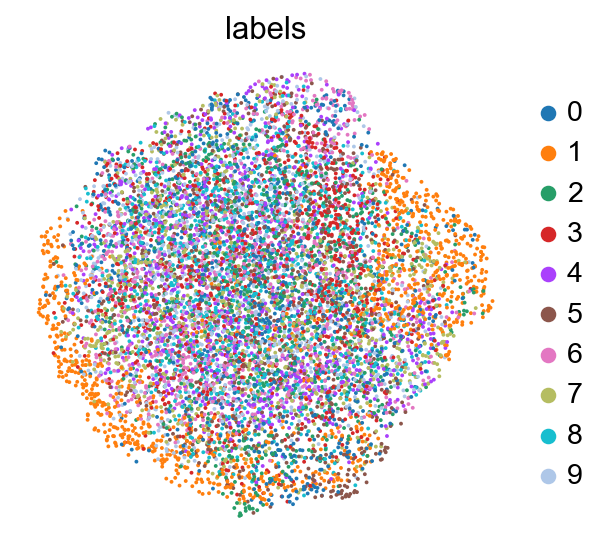

In [51]:
model.cpu()
output = model(test_data, cond1=test_labels )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


In [52]:
# CVAE
# p(x|z,c)p(z|c)p(z)
# q(z|x,c)
model = Mb0.VAE_AE_TypeB1500vC(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    nc1=10,
    #learned_prior=False,
    learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_AE_TypeB1500vC'>


In [53]:
Train.basicTrainLoopCond(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )

epoch's lr =  0.001
epoch 0
training phase
rec: 530.6594848632812
loss_z: 11.931011199951172
total_loss: 542.5905151367188

epoch's lr =  0.001
epoch 0
training phase
rec: 22.002294540405273
loss_z: 6.166990280151367
total_loss: 28.16928482055664

epoch's lr =  0.0001
epoch 0
training phase
rec: 20.459659576416016
loss_z: 6.755317211151123
total_loss: 27.214977264404297

epoch's lr =  1e-05
epoch 0
training phase
rec: 18.7564697265625
loss_z: 6.747952461242676
total_loss: 25.50442123413086

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


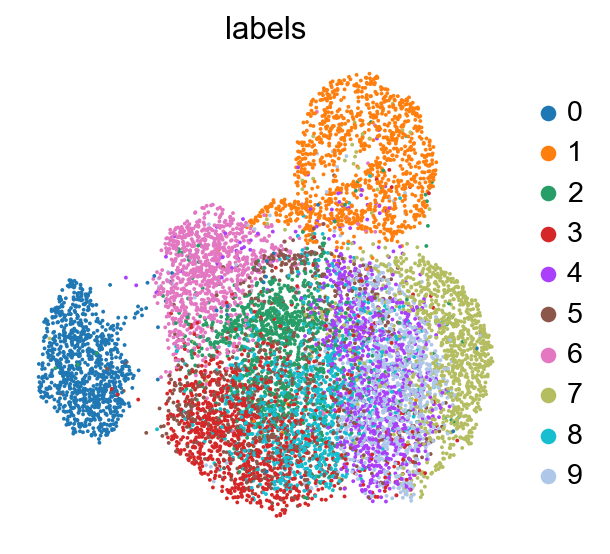

In [54]:
model.cpu()
output = model(test_data, cond1=test_labels )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


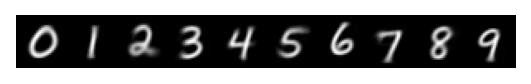

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 5.6825e-06,  5.6825e-06,  5.6825e-06],
         ...,
         [-3.9300e-06, -3.9300e-06, -3.9300e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  0

In [57]:
model.eval()
test_labels.shape
c = torch.eye(10)
model.nz
cz = model.Pz(c)
cz.shape
x = model.Px(
    torch.cat([cz[:,:model.nz], c],dim=-1)).reshape(-1,1,28,28)
ut.plot_images(x)

/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


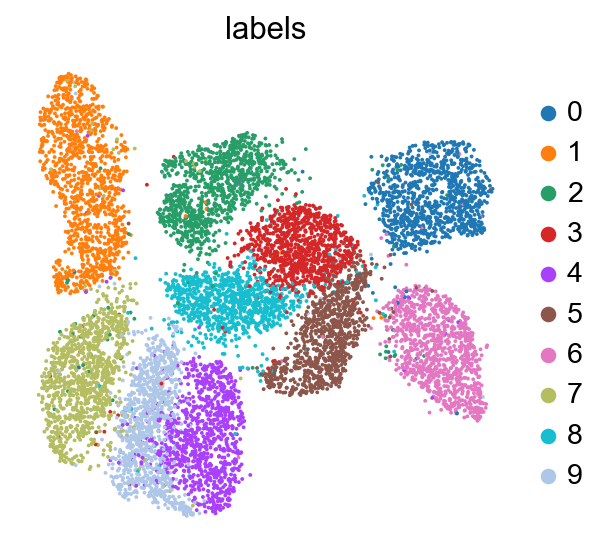

In [58]:
# pca umap
sc.pp.pca(adata,)
sc.pp.neighbors(adata,)
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )


In [59]:
# vanilla VAE 
model = Mb0.VAE_AE_TypeB1500v(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    #nc1=10,
    #learned_prior=False,
    #learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>


In [60]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 526.923583984375
loss_z: 4.3628950119018555
total_loss: 531.2864990234375

epoch's lr =  0.001
epoch 0
training phase
rec: 23.97205352783203
loss_z: 8.962821960449219
total_loss: 32.93487548828125

epoch's lr =  0.0001
epoch 0
training phase
rec: 22.81807518005371
loss_z: 9.215042114257812
total_loss: 32.033119201660156

epoch's lr =  1e-05
epoch 0
training phase
rec: 23.177597045898438
loss_z: 9.38620376586914
total_loss: 32.56380081176758

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


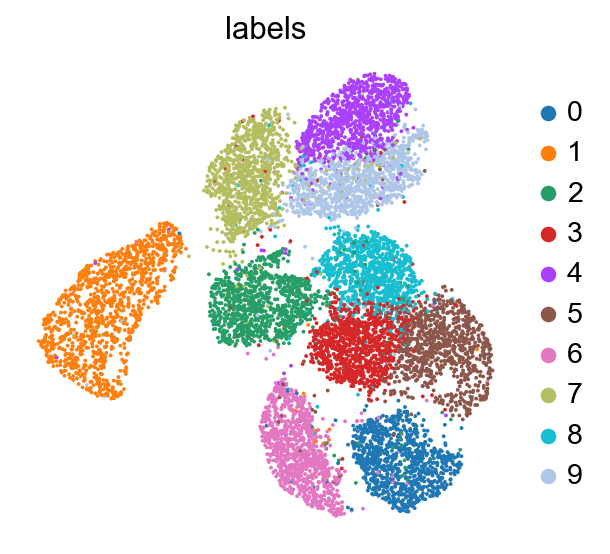

In [63]:
model.cpu()
output = model(test_data, )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


In [115]:
# sigma-VAE 
model = Mb0.VAE_AE_TypeB1500v(
    nx=adata.n_vars,
    #nz=64,
    nz=8,
    #dropout=0.2,
    dropout=0.25,
    #bn=True,
    #bn=False,
    #reclosstype="mse",
    reclosstype="Gauss",
    #reclosstype="Bernoulli",
    #restrict_z=False,
    restrict_z=True,
    #nc1=10,
    #learned_prior=False,
    #learned_prior=True,
    #numhidden=2,
    #numhiddenp=2,
    #numhiddenq=2,
)
#model = M7.VAE_Primer_Type700(
#    nx=adata.n_vars,
#    nz=64,
#)
model.apply(init_weights)
print(model.__class__)


<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>


In [118]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: -1424.6636962890625
loss_z: 21.378456115722656
total_loss: -1403.2852783203125

epoch's lr =  0.001
epoch 0
training phase
rec: -1448.6484375
loss_z: 21.56385040283203
total_loss: -1427.0845947265625

epoch's lr =  0.0001
epoch 0
training phase
rec: -1443.459228515625
loss_z: 21.45566177368164
total_loss: -1422.0035400390625

epoch's lr =  1e-05
epoch 0
training phase
rec: -1578.1934814453125
loss_z: 21.713829040527344
total_loss: -1556.4796142578125

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


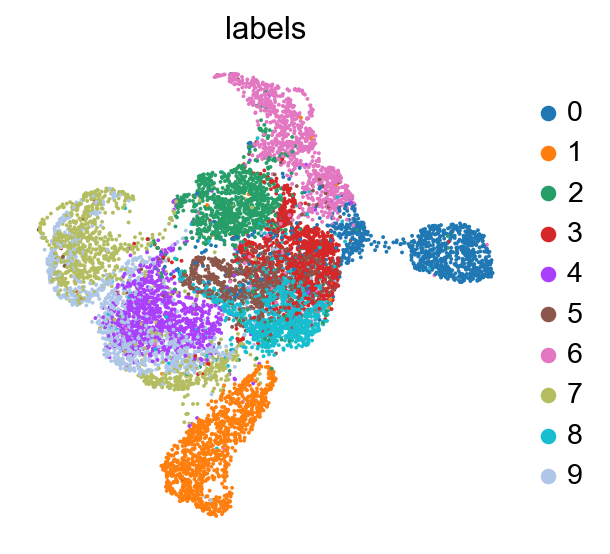

In [119]:
model.cpu()
output = model(test_data, )
#adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
#sc.pp.neighbors(adata,use_rep="mu_z")
sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


In [91]:
# vanilla AE
model = Mb0.AE_TypeB1500(
    nx=adata.n_vars,
    nz=8,
    dropout=0.25,
    bn=True,
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    restrict_z=True,
    #nc1=10,
    #learned_prior=False,
    #learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)

<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>
<class 'gmmvaeBeta00.AE_TypeB1500'>


In [92]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=10,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 536.723876953125
total_loss: 536.723876953125

epoch's lr =  0.001
epoch 0
training phase
rec: 19.902402877807617
total_loss: 19.902402877807617

epoch's lr =  0.0001
epoch 0
training phase
rec: 16.673133850097656
total_loss: 16.673133850097656

epoch's lr =  1e-05
epoch 0
training phase
rec: 16.64815330505371
total_loss: 16.64815330505371

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


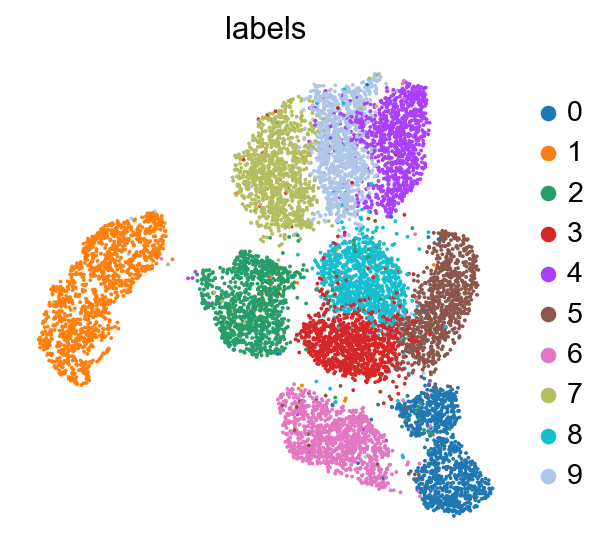

In [93]:
model.cpu()
output = model(test_data, )
#adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
#sc.pp.neighbors(adata,use_rep="mu_z")
sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


In [126]:
# sigma-vae
model = Mb0.VAE_AE_TypeB1500v(
    nx=adata.n_vars,
    nz=88,
    #nz=64,
    #dropout=0.2,
    dropout=0.25,
    #bn=True,
    bn=False,
    #reclosstype="mse",
    reclosstype="Gauss",
    #reclosstype="Bernoulli",
    #restrict_z=False,
    restrict_z=True,
    #nc1=10,
    #learned_prior=False,
    #learned_prior=True,
    #numhidden=2,
    #numhiddenp=2,
    #numhiddenq=2,
)
model.apply(init_weights)
print(model.__class__)


<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>


In [127]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=8,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 793.5941772460938
loss_z: 5.357637882232666
total_loss: 798.9518432617188

epoch's lr =  0.001
epoch 0
training phase
rec: -902.14794921875
loss_z: 21.325210571289062
total_loss: -880.82275390625

epoch's lr =  0.0001
epoch 0
training phase
rec: -1300.3922119140625
loss_z: 23.930618286132812
total_loss: -1276.4615478515625

epoch's lr =  1e-05
epoch 0
training phase
rec: -1310.5611572265625
loss_z: 23.640029907226562
total_loss: -1286.921142578125

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


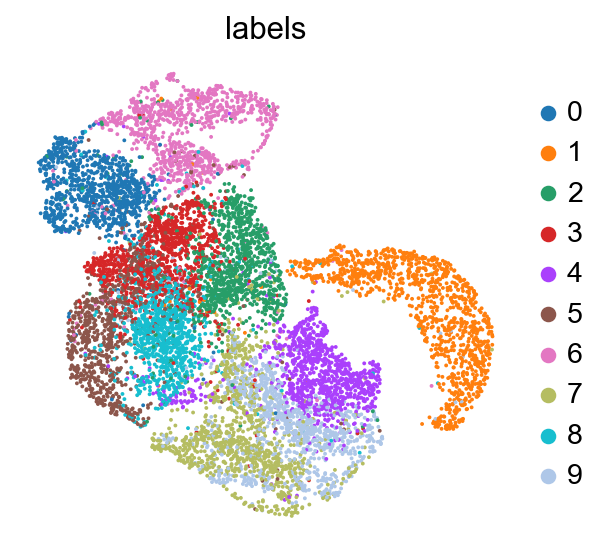

In [130]:
model.cpu()
output = model(test_data, )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


In [152]:
model = Mb0.VAE_AE_TypeB1500v(
    nx=adata.n_vars,
    nz=18,
    dropout=0.15,
    #bn=True,
    #reclosstype="Bernoulli",
    reclosstype="mse",
    #reclosstype="Gauss",
    #restrict_z=False,
    #restrict_z=True,
    #nc1=10,
    #learned_prior=False,
    #learned_prior=True,
)
model.apply(init_weights)
print(model.__class__)


<class 'gmmvaeBeta00.VAE_AE_TypeB1500v'>


In [153]:
Train.basicTrainLoop(
        model,
        data_loader,
        None,
        num_epochs=20,
        report_interval=45,
        lrs = [1e-3,1e-3,1e-4,1e-5,],
        #lrs = [1e-3,1e-3,1e-3,1e-4,1e-5,],
        #wt=1e-4,
        )


epoch's lr =  0.001
epoch 0
training phase
rec: 535.4854736328125
loss_z: 13.005845069885254
total_loss: 548.4913330078125

epoch's lr =  0.001
epoch 0
training phase
rec: 21.311908721923828
loss_z: 9.93515682220459
total_loss: 31.247066497802734

epoch's lr =  0.0001
epoch 0
training phase
rec: 19.693706512451172
loss_z: 10.432076454162598
total_loss: 30.125782012939453

epoch's lr =  1e-05
epoch 0
training phase
rec: 20.702648162841797
loss_z: 10.674206733703613
total_loss: 31.376853942871094

done training


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


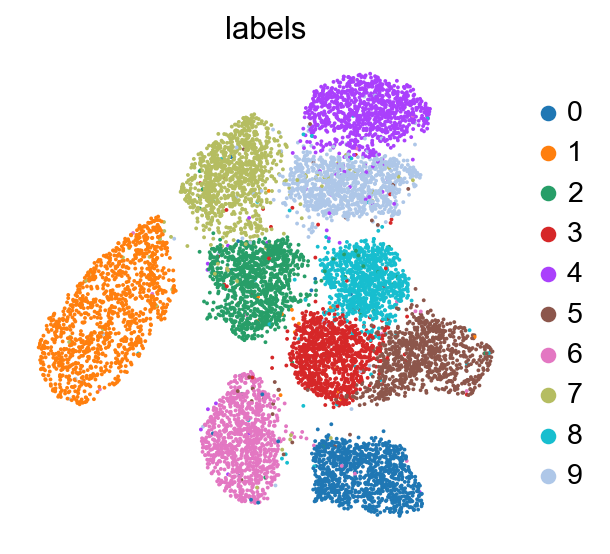

In [154]:
model.cpu()
output = model(test_data, )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
sc.pp.neighbors(adata,use_rep="mu_z")
#sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


/home/ykolb/miniconda3/envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


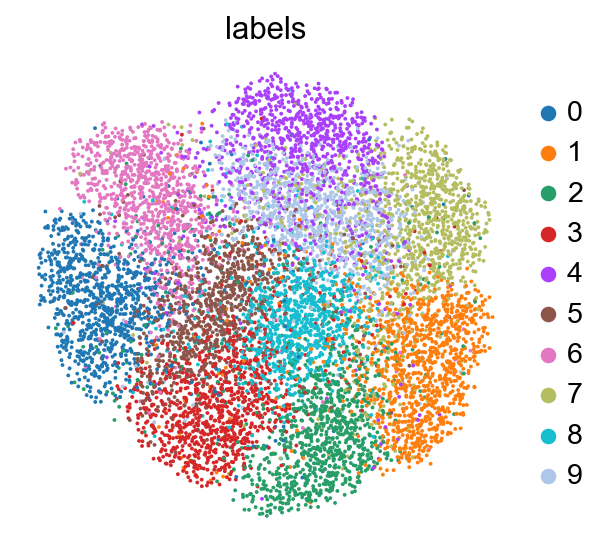

In [155]:
model.cpu()
output = model(test_data, )
adata.obsm["mu_z"] = output["mu_z"].detach().numpy()
adata.obsm["z"] = output["z"].detach().numpy()
#sc.pp.neighbors(adata,use_rep="mu_z")
sc.pp.neighbors(adata,use_rep="z")
sc.tl.umap(adata, )
sc.tl.louvain(adata,)
sc.pl.umap(adata, 
           color=[
               "labels",
               #"louvain",
           ], 
        frameon=False,
        #legend_loc='on data',
        #legend_fontsize=7,
        ncols=2,
        #color_map="magma",
        )
del output


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


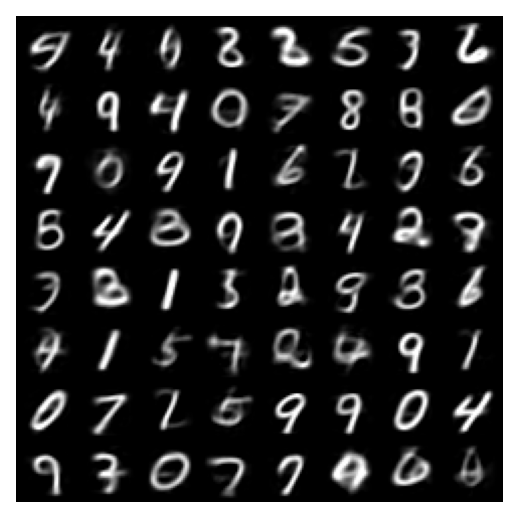

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 8.0002e-06,  8.0002e-06,  8.0002e-06],
         ...,
         [ 7.3631e-06,  7.3631e-06,  7.3631e-06],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

        ...,

        [[ 0.0000e+00,  0.0000e+00,  0

In [156]:
z = torch.randn(16*4, model.nz)
x = model.Px(z).reshape(-1,1,28,28)
ut.plot_images(x, nrow=8)